**Differentially private monotone regression** 

This tutorial details the private computation of a monotone regression model, based on the theory and results of the following preprint:

[Privacy-Preserving Convex Optimization: When Differential Privacy Meets Stochastic Programming]() (2022) by Vladimir Dvorkin, Ferdinando Fioretto, Pascal Van Hentenryck, Pierre Pinson and Jalal Kazempour. 

***

In [1]:
# activate project environment
using Pkg
Pkg.activate()

# load packages 
using Plots
using Distributions, Random
using JuMP, Mosek, MosekTools
using LinearAlgebra, SparseArrays, Calculus

  Activating environment at `~/.julia/environments/v1.6/Project.toml`


Consider the problem of fitting a smooth function $h(x)$ to a set of observations $(x_{1},y_{1}),\dots,(x_{n},y_{n})$, subject to the constraint that $h$ must be monotone in the range of $x$. Such constraints originate in regression problems, where the underlying phenomenon is known to be monotone, e.g., wind power curve fitting \cite{mehrjoo2020wind}. The function is modeled as $h(x)=w^{\top}\varphi(x)$, where $w\in\mathbb{R}^{m}$ is a vector of weights and $\varphi(x)\in\mathbb{R}^{m}$ is a high-dimensional basis function. Function $h(x)$ fits data when the regularized regression loss $$\underset{w}{\text{minimize}}\quad\sum_{i=1}^{n}\lVert y_{i} - w^{\top}\varphi(x_{i})\rVert + \lambda\lVert w \rVert$$ is minimized subject to constraint $Cw\geqslant\mathbb{0}$, where matrix $C\in\mathbb{R}^{p\times m}$ encodes monotonic conditions at $p$ selected points, i.e., its $i^{\text{th}}$ raw contains partial derivatives $\varphi'(u_{i})$ of the basis function evaluated at selected point $u_{i}$ in the range of $x$. 

The privacy goal here is to make regression weights $w$ statistically similar on adjacent regression datasets. The application of the standard output perturbation strategy $w^{\star} + \hat{\zeta}$, however, does not guarantee that the perturbed weights are feasible, i.e., that $C(w^{\star} + \hat{\zeta})\geqslant\mathbb{0}$. To guarantees feasibility, we first redefine the weights as linear decision rule $w({\zeta}) = \overline{w} + W{\zeta}$, where $\overline{w}\in\mathbb{R}^{m}$ and $W\in\mathbb{R}^{m\times m}$ are optimization variables, and then put forth the following chance-constrained program
\begin{align*}
    \underset{\overline{w},W}{\text{minimize}}\quad&\mathbb{E}\left[\sum_{i=1}^{n}\lVert y_{i} - (\overline{w} + W{\zeta})^{\top}\varphi(x_{i})\rVert + \lambda\lVert \overline{w} + W{\zeta}\rVert\right]\\
    \text{subject to}\quad&\text{Pr}\left[
    C(\overline{w} + W{\zeta})\geqslant\mathbb{0}
    \right]\geqslant1-\eta,\quad W = I,
\end{align*}
which minimizes the expected regression loss, while requiring constraint satisfaction with probability $(1-\eta)$ and additionally enforcing the identity query constraints to guarantee noise independence. Unlike the deterministic problem, this stochastic program optimizes mean weights $\overline{w}$ anticipating the impact of the perturbation on the probability of monotonic constraint satisfaction. Once the chance-constrained program is solved to optimality, the differently private regression weights release is $\overline{w}^{\star} + \hat{\zeta}$, where $\hat{\zeta}$ is a random realization of ${\zeta}$.

We illustrate the private monotonic regression by approximating the following function:
\begin{align*}
y(x) = \mathbb{1}^{\top}
\begin{bmatrix}
x\\
\frac{1}{2}(x-5)^3
\end{bmatrix}
+z,\quad z\sim N(0,15),
\end{align*}
with the linear and cubic basis functions and some random noise $z$. The regression dataset is generated from this function using 100 independent variables $x$ drawn from the uniform distribution $U(0,10)$. 

In [2]:
# generate problem data
Random.seed!(10)
n = 100; x = rand(Uniform(0,10),n); x = sort!(x)
# chose basis function and generate dependent variable
φ(x) = [x 0.5*(x.-5).^3]; m = size(φ(1),2)
# weights of basis functions and dependent variable
β = [1;1]
y = φ(x) * β .+ rand(Normal(0,15),n)

## build constraint matrix and save data
p = 2; C = zeros(p,m); point = [1 9.0]
for i in 1:p
    # point[i] = rand(Uniform(0,1))
    C[i,:] = Calculus.gradient(x -> φ(x), point[i])
end
sign_ = sign.([Calculus.gradient(x -> φ(x)*β, point[i])[1] for i in 1:p])

# save problem data
data = Dict(:n => n, :m => m, :y => y, :x => x, :C => C, :point => point, :sign_ => sign_,
            :y_scale => 8, :x_scale => 0.35)

Dict{Symbol, Any} with 9 entries:
  :C       => [1.0 24.0; 1.0 24.0]
  :m       => 2
  :sign_   => [1.0, 1.0]
  :n       => 100
  :y       => [-56.3222, -38.8301, -65.659, -40.2812, -52.3448, -74.5349, -49.7…
  :y_scale => 8
  :x_scale => 0.35
  :point   => [1.0 9.0]
  :x       => [0.0165774, 0.112278, 0.119852, 0.566454, 0.5878, 0.66098, 0.6725…

The the best deterministic fit is obtained by optimizing a linear regression model using the following quadratic problem: 

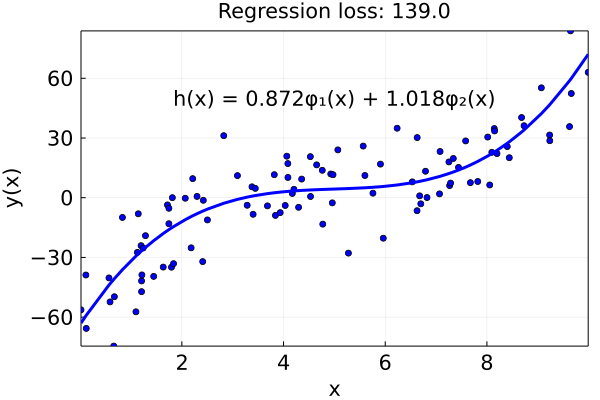

┌ Info: loss of the base fit is 1148.610195883934
└ @ Main /Users/vladimirdvorkin/Desktop/PrivateOpt/tutorials/QP_monotone_regression/PrivateRegression.ipynb:18


In [3]:
function fit_model(data)
    model = Model(optimizer_with_attributes(Mosek.Optimizer, "LOG" => 0))

    @variable(model, β[1:data[:m]])
    @variable(model, t)

    @objective(model, Min, t)

    @constraint(model, [t;data[:y] .- φ(data[:x]) * β] in SecondOrderCone())
    @constraint(model, diagm(data[:sign_])*data[:C] * β .>= 0)

    optimize!(model)
    return Dict(:β => JuMP.value.(β), :loss => JuMP.objective_value.(model))
end

## solve the base fit problem
sol = fit_model(data)
@info("loss of the base fit is $(norm(data[:y] .- φ(data[:x]) * sol[:β],1))")

## plot data and base fitting
plot_base = plot(legend=false,xlim=(minimum(data[:x]),maximum(data[:x])),ylim=(minimum(data[:y]),maximum(data[:y])),
            xlabel="x", ylabel="y(x)",framestyle = :box, xtickfontsize=14,ytickfontsize=14, labelfontsize=14)
scatter!(data[:x],data[:y], label = "observation", c=:blue)
plot!(data[:x],φ(data[:x])*sol[:β], label = "model", lw =3, c=:blue)
annotate!([(5,50,text("h(x) = $(round(sol[:β][1],digits=3))φ₁(x) + $(round(sol[:β][2],digits=3))φ₂(x)", 10, :top, :black, Plots.font(14)))])
plot!(title="Regression loss: $(round(norm(data[:y] .- φ(data[:x]) * sol[:β],2),digits=1))")
display(plot_base)

We assume a dataset universes $\mathbb{D}$, where $i^{\text{th}}$ data point realizes according to the law $(0.35r\cos(t)+x_{i},8r\sin(t)+y_{i}),$ where $r\sim U(0,1)$ and $t\sim U(0,2\pi)$, i.e., from the scaled circle domains centered at $(x_{i},y_{i})$. We can observe that the linear regression parameters are unique for each data instance from this universe.  

┌ Info: Saved animation to 
│   fn = /Users/vladimirdvorkin/Desktop/PrivateOpt/tutorials/QP_monotone_regression/animation.gif
└ @ Plots /Users/vladimirdvorkin/.julia/packages/Plots/Xv2qA/src/animation.jl:114


Plots.AnimatedGif("/Users/vladimirdvorkin/Desktop/PrivateOpt/tutorials/QP_monotone_regression/animation.gif")
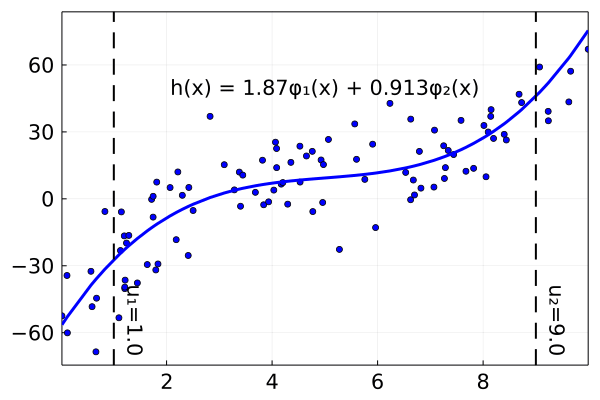

In [4]:
function make_a_gif(data)
    data_new = deepcopy(data)
    # choose random points
    # N_points = 30; Random.seed!(1); subset = rand(1:100, N_points)
    N_points = 100; Random.seed!(1); subset = 1:100

    k = 50
    t = range(0, 1, length = k)
    x_ = zeros(N_points,k)
    y_ = zeros(N_points,k)
    for i in 1:N_points
        r = rand()
        θ = rand(Uniform(0,2*π))
        if i <= N_points/2
            x_[i,:] = data[:x_scale].*sqrt(r).*sin.(t.*θ) .+ data_new[:x][subset[i]]
            y_[i,:] = data[:y_scale].*sqrt(r).*cos.(t.*θ) .+ data_new[:y][subset[i]]
        else
            x_[i,:] = data[:x_scale].*sqrt(r).*sin.(-t.*θ) .+ data_new[:x][subset[i]]
            y_[i,:] = data[:y_scale].*sqrt(r).*cos.(-t.*θ) .+ data_new[:y][subset[i]]
        end
    end

    anim = @animate for i ∈ 1:k
        data_new[:x][subset] .= x_[:,i]
        data_new[:y][subset] .= y_[:,i]

        sol = fit_model(data_new)

        plot(legend=false,framestyle = :box, xtickfontsize=14, ytickfontsize=14, labelfontsize=14)
        plot!(xlim=(minimum(data[:x]),maximum(data[:x])))
        plot!(ylim=(minimum(data[:y]),maximum(data[:y])))

        annotate!([(5,50,text("h(x) = $(round(sol[:β][1],digits=3))φ₁(x) + $(round(sol[:β][2],digits=3))φ₂(x)", 10, :top, :black, Plots.font(14)))])
        annotate!([(data[:point][1]+0.4,minimum(data[:y])+20,text("u₁=$(data[:point][1])", 10, :top, :black, rotation=-90, Plots.font(14)))])
        annotate!([(data[:point][2]+0.4,minimum(data[:y])+20,text("u₂=$(data[:point][2])", 10, :top, :black, rotation=-90, Plots.font(14)))])

        scatter!(data_new[:x],data_new[:y],c=:blue)

        ind = sortperm(data_new[:x]) # order data
        plot!(data_new[:x][ind],φ(data_new[:x][ind])*sol[:β], lw =3, c=:blue)

        vline!(point,label="",c=:black,lw=2,linestyle=:dash)
    end
    return gif(anim, "animation.gif", fps = 10)
end

make_a_gif(data)

In this tutorial, we provide $(1,0.01)$-differential privacy for any dataset from the universe $\mathbb{D}$, i.e., $\varepsilon=1,\delta=0.01$ and $\alpha=\infty$. The sensitivity $\Delta_{2}$ of the baseline model (regression weights) to datasets evaluates at 0.46 using Algorithm 1 with sample size requirement $S=199$ (for $\gamma=0.5,\beta=0.1$ of Proposition 3.2). 

In [5]:
set = Dict(:ε => 1, :δ => 0.01,    # differential privacy parameters
            :η => 0.03, :Σ => [],  # chance constraints settings
            :Ns => 200, :Δ => 0)   # sensitivity settings 

function sampled_sensitivity(data,set)
    Δ_β = zeros(2,data[:m],set[:Ns])
    Δ_β_norm = zeros(set[:Ns])

    for i in 1:set[:Ns]
        # first run
        data_ = deepcopy(data)
        for j in 1:data[:n]
            r = rand()
            θ = rand(Uniform(0,2*π))
            data_[:x][j] = data[:x][j] .+ data[:x_scale]*sqrt(r)*sin.(θ)
            data_[:y][j] = data[:y][j] .+ data[:y_scale]*sqrt(r)*cos.(θ)
        end
        sol = fit_model(data_)
        Δ_β[1,:,i] .= sol[:β]
        # second run
        data_ = deepcopy(data)
        for j in 1:data[:n]
            r = rand()
            θ = rand(Uniform(0,2*π))
            data_[:x][j] = data[:x][j] .+ data[:x_scale]*sqrt(r)*sin.(θ)
            data_[:y][j] = data[:y][j] .+ data[:y_scale]*sqrt(r)*cos.(θ)
        end
        sol = fit_model(data_)
        Δ_β[2,:,i] .= sol[:β]
        # distance
        Δ_β_norm[i] = norm(Δ_β[1,:,i] - Δ_β[2,:,i],2)
    end
    return Dict(:Δ => maximum(Δ_β_norm), :Δ_β_norm => Δ_β_norm)
end

## compute global sensitivity
sense = sampled_sensitivity(data,set)
set[:Δ] = sense[:Δ]
set[:Σ] = diagm(ones(data[:m])*sqrt(2*log(1.25/set[:δ]))*set[:Δ]^2/set[:ε])

2×2 Matrix{Float64}:
 0.445047  0.0
 0.0       0.445047

We first deploy the output perturbation strategy using the Gaussian mechanism, i.e., by perturbing the weights of the baseline model with the Gaussian noise $N(0,\sqrt{2\text{ln}(1.25/0.01)}0.46)$, and illustrate the results in  a plot bellow. 

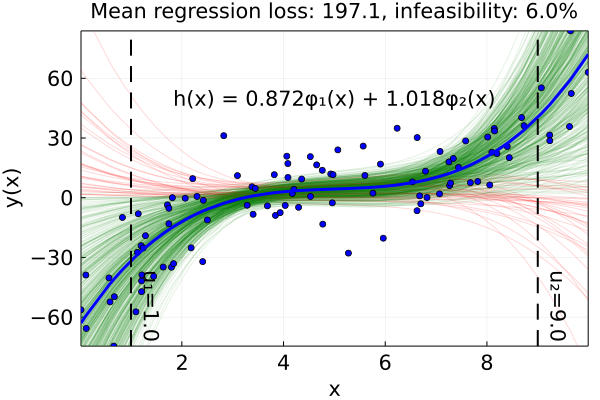

┌ Info: mean loss of the OP fit is 197.06017014634534
└ @ Main /Users/vladimirdvorkin/Desktop/PrivateOpt/tutorials/QP_monotone_regression/PrivateRegression.ipynb:20
┌ Info: infeasinity of the OP fit is 6.0%
└ @ Main /Users/vladimirdvorkin/Desktop/PrivateOpt/tutorials/QP_monotone_regression/PrivateRegression.ipynb:21


In [6]:
## output pertubation strategy
plo_op = plot(legend=false,xlim=(minimum(data[:x]),maximum(data[:x])),ylim=(minimum(data[:y]),maximum(data[:y])),
            xlabel="x", ylabel="y(x)",framestyle = :box, xtickfontsize=14,ytickfontsize=14, labelfontsize=14)
acc = 0; inf = 0;
for i in 1:10000
    β̂ = sol[:β] .+ rand(MvNormal(zeros(data[:m]),set[:Σ]))
    if sign.([Calculus.gradient(x -> φ(x)*β̂, point[i])[1] for i in 1:p])[1] == 1
        if i <= 500
            plot!(data[:x],φ(data[:x])*β̂, label = "", lw =1, c=:green, alpha=0.1)
        end
    else
        if i <= 500
            plot!(data[:x],φ(data[:x])*β̂, label = "", lw =1, c=:red, alpha=0.15)
        end
        inf += 1
    end
    # plot!(data[:x],φ(data[:x])*β̂, label = "", lw =1, c=:gray, alpha=0.1)
    acc += (norm(data[:y] .- φ(data[:x]) * β̂,2))
end
@info("mean loss of the OP fit is $(acc/10000)")
@info("infeasinity of the OP fit is $(inf/10000*100)%")
scatter!(x,y, label = "observation", c=:blue)
plot!(data[:x],φ(data[:x])*sol[:β], label = "model (mean)", lw =3, c=:blue)
vline!(point,label="",c=:black,lw=2,linestyle=:dash)
annotate!([(5,50,text("h(x) = $(round(sol[:β][1],digits=3))φ₁(x) + $(round(sol[:β][2],digits=3))φ₂(x)", 10, :top, :black, Plots.font(14)))])
annotate!([(data[:point][1]+0.4,minimum(data[:y])+20,text("u₁=$(data[:point][1])", 10, :top, :black, rotation=-90, Plots.font(14)))])
annotate!([(data[:point][2]+0.4,minimum(data[:y])+20,text("u₂=$(data[:point][2])", 10, :top, :black, rotation=-90, Plots.font(14)))])
plot!(title="Mean regression loss: $(round(acc/10000,digits=1)), infeasibility: $(round(inf/10000*100,digits=1))%")
display(plo_op)

Observe, that the output perturbation is likely to violate the original monotonic conditions of the baseline model. To measure violations, we select two points $u_{1}=1$ and $u_{2}=9$ in the range of $x$ and build the constraint matrix

\begin{align*}
C=
\begin{bmatrix}
\partial\varphi_{1}(u_{1})/\partial u_{1} & \partial\varphi_{2}(u_{1})/\partial u_{1}\\
\partial\varphi_{1}(u_{2})/\partial u_{2}& \partial\varphi_{2}(u_{2})/\partial u_{2}
\end{bmatrix}
=
\begin{bmatrix}
1.00 & 36.75\\
1.00 & 48.00
\end{bmatrix},
\end{align*}

and we record violation whenever $C(w^{\star}+\hat{\zeta})\geqslant0$ does not hold under perturbation. For output perturbation, this constraint is violated in 9.8\% instances across 500 perturbed models shown in either green or red depending whether they monotone increasing or decreasing.  

Next, we deploy the program perturbation strategy by first solving the chance-constrained program and then perturbing its mean solution $\overline{w}$. Here, we require the monotonic constraint satisfaction with probability at least $97\%$ ($\eta$ is set to 3\%). 

┌ Info: model status : OPTIMAL
└ @ Main /Users/vladimirdvorkin/Desktop/PrivateOpt/tutorials/QP_monotone_regression/PrivateRegression.ipynb:20
┌ Info: mean loss of the PP fit is 210.52566814868013
└ @ Main /Users/vladimirdvorkin/Desktop/PrivateOpt/tutorials/QP_monotone_regression/PrivateRegression.ipynb:45


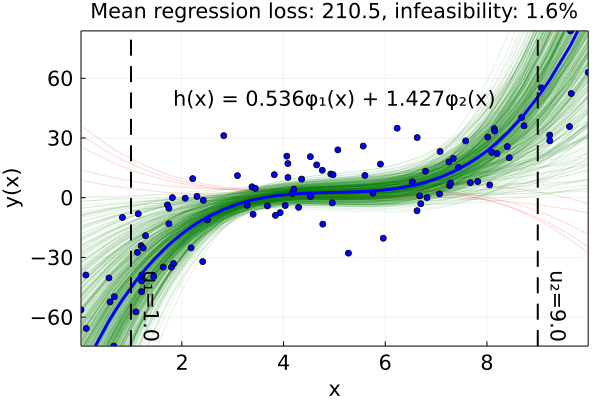

┌ Info: infeasinity of the PP fit is 1.55%
└ @ Main /Users/vladimirdvorkin/Desktop/PrivateOpt/tutorials/QP_monotone_regression/PrivateRegression.ipynb:46


In [7]:
## program pertubation strategy

Φ(x) = quantile(Normal(0,1),1-x)

function fit_model_sto(data,set)

    model = Model(optimizer_with_attributes(Mosek.Optimizer, "LOG" => 0))

    @variable(model, β[1:data[:m]])
    @variable(model, B[1:data[:m],1:data[:m]])
    @variable(model, t)

    @objective(model, Min, t + sum(tr(φ(data[:x][i])*B'*set[:Σ]*B*φ(data[:x][i])') for i in 1:data[:n]))

    @constraint(model, [t;data[:y] .- φ(data[:x]) * β] in SecondOrderCone())
    @constraint(model, con[i=1:size(data[:C],1)], [(data[:C]*β)[i]; Φ(set[:η]/data[:m]) *  Matrix{Float64}(cholesky(set[:Σ]).L) * (data[:C]*B)[i,:]] in SecondOrderCone())
    @constraint(model, B .== Matrix{Float64}(I(data[:m])))

    optimize!(model)
    @info("model status : $(termination_status(model))")

    return Dict(:β => JuMP.value.(β), :B => JuMP.value.(B), :loss => JuMP.objective_value.(model))
end

sol_sto = fit_model_sto(data,set)
plo_pp = plot(legend=:false,xlim=(minimum(data[:x]),maximum(data[:x])),ylim=(minimum(data[:y]),maximum(data[:y])),
            xlabel="x", ylabel="y(x)",framestyle = :box, xtickfontsize=14,ytickfontsize=14, labelfontsize=14)
acc = 0; inf = 0
for i in 1:10000
    β̂ = sol_sto[:β] .+ rand(MvNormal(zeros(data[:m]),set[:Σ]))
    if sign.([Calculus.gradient(x -> φ(x)*β̂, point[i])[1] for i in 1:p])[1] == 1
        if i <= 500
            plot!(data[:x],φ(data[:x])*β̂, label = "", lw =1, c=:green, alpha=0.1)
        end
    else
        if i <= 500
            plot!(data[:x],φ(data[:x])*β̂, label = "", lw =1, c=:red, alpha=0.15)
        end
        inf += 1
    end
    # plot!(data[:x],φ(data[:x])*β̂, label = "", lw =1, c=:gray, alpha=0.1)
    acc += (norm(data[:y] .- φ(data[:x]) * β̂,2))
end

@info("mean loss of the PP fit is $(acc/10000)")
@info("infeasinity of the PP fit is $(inf/10000*100)%")

scatter!(x,y, label = "observation", c=:blue)
plot!(data[:x],φ(data[:x])*sol_sto[:β], label = "model (mean)", lw =3, c=:blue)
vline!(point,label="",c=:black,lw=2,linestyle=:dash)

annotate!([(5,50,text("h(x) = $(round(sol_sto[:β][1],digits=3))φ₁(x) + $(round(sol_sto[:β][2],digits=3))φ₂(x)", 10, :top, :black,Plots.font(14)))])
annotate!([(data[:point][1]+0.4,minimum(data[:y])+20,text("u₁=$(data[:point][1])", 10, :top, :black, rotation=-90,Plots.font(14)))])
annotate!([(data[:point][2]+0.4,minimum(data[:y])+20,text("u₂=$(data[:point][2])", 10, :top, :black, rotation=-90,Plots.font(14)))])

plot!(title="Mean regression loss: $(round(acc/10000,digits=1)), infeasibility: $(round(inf/10000*100,digits=1))%")
display(plo_pp)

The results show that the mean regression model deviates from the baseline model, but the constraint violation probability on 500 samples is small, below the prescribed maximum violation probability of 3\%. This feasibility guarantee, however, comes at the expense of an increasing regression loss, which exceeds that of the output perturbation by 18.4\% in expectation, thus revealing the inherent trade-offs between feasibility and the goodness of fit.  